# Oppgave 3

## 2)

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fft, fftfreq, fftshift, ifft, ifftshift
import pandas as pd
from tqdm import tqdm

In [43]:
def plot_stability(r, xlim, ylim, resolution=500):
    
    x = np.linspace(xlim[0], xlim[1], resolution)
    y = np.linspace(ylim[0], ylim[1], resolution)
    X, Y = np.meshgrid(x,y)
    Z = X + 1j*Y
    
    R = np.abs(r(Z))
    
    plt.figure(figsize=(5,5))
    plt.contourf(X, Y, R, levels=[0,1], colors=['blue'], alpha=0.5)
    plt.contour(X, Y, R, levels=[1], colors=['black'])
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')
    plt.title(f'Stabilitetsområde, $θ = {θ}$')
    plt.grid(); plt.show()
    
def r(z):
    return (1+(1-θ)*z)/(1-θ*z)

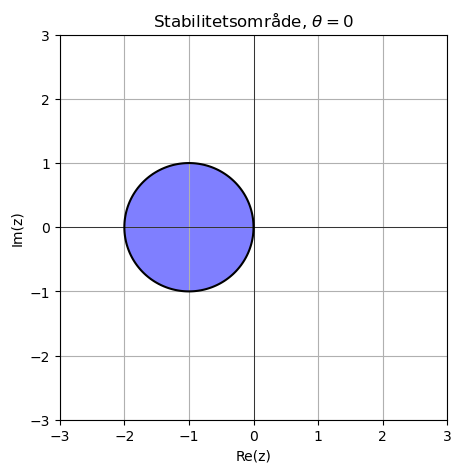

In [11]:
θ = 0

plot_stability(r, xlim=(-3,3), ylim=(-3,3))

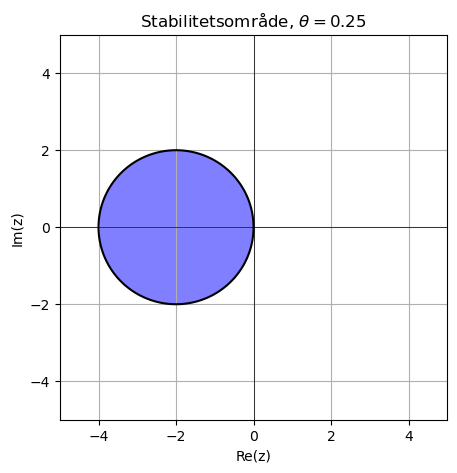

In [14]:
θ = 0.25

plot_stability(r, xlim=(-5,5), ylim=(-5,5))

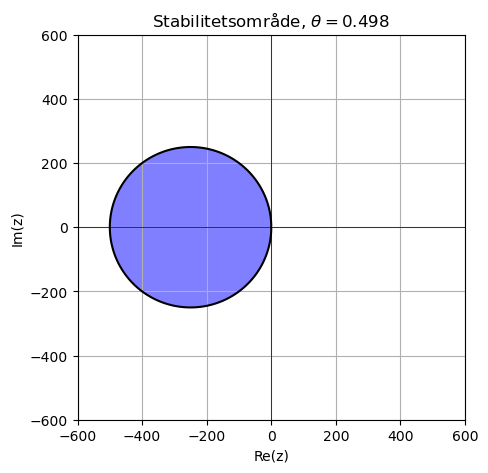

In [20]:
θ = 0.498

plot_stability(r, xlim=(-600,600), ylim=(-600,600))

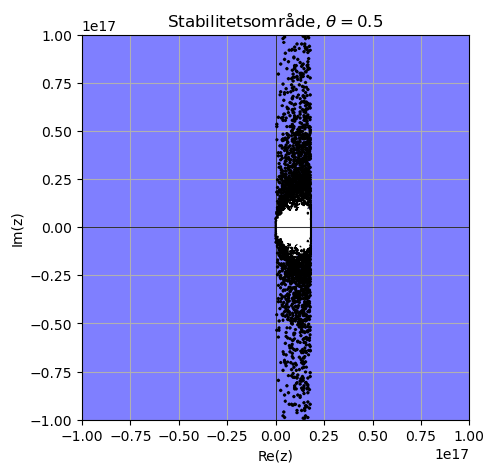

In [32]:
θ = 0.5

plot_stability(r, xlim=(-1e17,1e17), ylim=(-1e17,1e17))

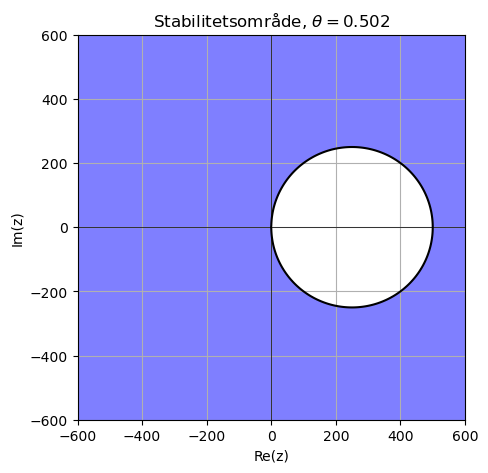

In [33]:
θ = 0.502

plot_stability(r, xlim=(-600,600), ylim=(-600,600))

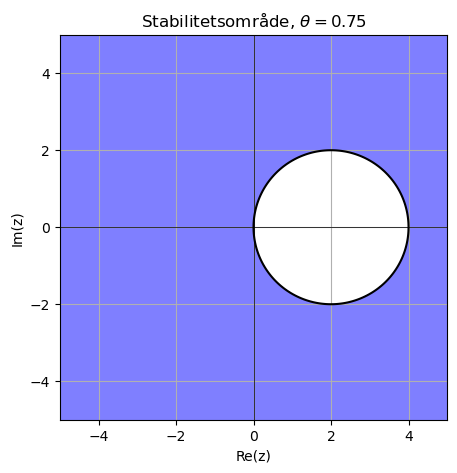

In [42]:
θ = 0.75

plot_stability(r, xlim=(-5,5), ylim=(-5,5))

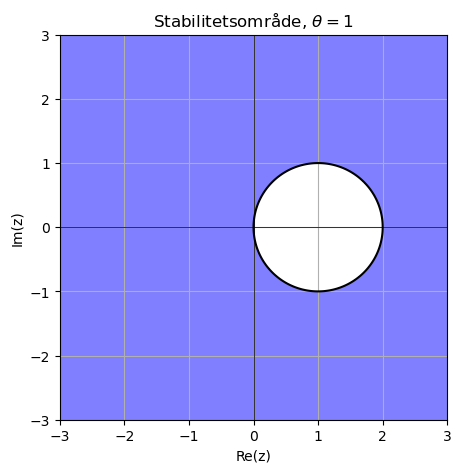

In [40]:
θ = 1

plot_stability(r, xlim=(-3,3), ylim=(-3,3))

# Oppgave 4

## 2)

In [275]:
def cahn_hilliard_backward_euler(*, kappa, X, Y, U0, t0, T, Nt, g, alpha=1.5):
    x, y = X[0,:], Y[:,0]
    if Nx < 2 or Ny < 2:
        raise ValueError('Grids must have at least two points in each space direction!')
    dx, dy = x[1]-x[0], y[1]-y[0]
    
    kx = fftfreq(Nx, d=dx/(2*np.pi))
    ky = fftfreq(Ny, d=dy/(2*np.pi))
    KX, KY = np.meshgrid(kx, ky, sparse=True)
    K2 = KX**2 + KY**2
    K4 = K2**2
    
    t = t0
    dt = (T-t0)/Nt
    
    U_hat = fft2(U0)
    
    yield(U_hat, t) 
    
    with tqdm(total=T) as pbar:
        while t < T-dt/2:
            if g is not None:
                G_hat = fft2(g(X,Y,t+dt))
            else:
                G_hat = 0
            
            U = ifft2(U_hat)
            N_U = np.array(U)**3
            N_U_hat = fft2(N_U)
            U_hat = (U_hat + dt*((1+alpha)*K2*U_hat - K2*N_U_hat + G_hat))/(1 + dt*(kappa*K4 + alpha*K2))

#             U_hat = (U_hat + dt*G_hat)/(1 - dt*K4)
    
            t += dt
            
            pbar.update(dt)
            yield (U_hat, t)

## 3)

In [274]:
def manufacture_solution_cahn_hilliard(u_str, kappa):
    import sympy as sy
    from sympy import sin, cos, exp
    
    x, y, t = sy.symbols('x y t')
    u_sy = eval(u_str)
    laplace = lambda u: sy.diff(u, x, x) + sy.diff(u, y, y)
    biharmonic = lambda u: sy.diff(u, x, x, x, x) + sy.diff(u, y, y, y, y) + 2*sy.diff(u, x, x, y, y)
    g_sy = sy.diff(u_sy, t) - sy.simplify(laplace(u_sy**3-u_sy)) + kappa*sy.simplify(biharmonic(u_sy))

#     g_sy = sy.diff(u_sy, t) - sy.simplify(biharmonic(u_sy))

    u = sy.lambdify((x, y, t), u_sy, modules='numpy')
    g = sy.lambdify((x, y, t), g_sy, modules='numpy')
    
    print(f'u = {u_sy}')
    print(f'u0 = {u_sy.subs(t,0)}')
    print(f'g = {g_sy}')
    
    return u, g

In [260]:
kappa = 1.0
u_ex_str = 'sin(x)*cos(y)*exp(-4*kappa*t)'
u_ex, g = manufacture_solution_cahn_hilliard(u_ex_str, kappa)

u = exp(-4.0*t)*sin(x)*cos(y)
u0 = sin(x)*cos(y)
g = -((6 - 9*sin(x)**2)*exp(4.0*t)*cos(y)**2 + (9*sin(y)**2 - 3)*exp(4.0*t)*sin(x)**2 + 2*exp(12.0*t))*exp(-16.0*t)*sin(x)*cos(y) - 4.0*exp(-4.0*t)*sin(x)*cos(y)


In [207]:
Lx, Ly = 16*np.pi, 16*np.pi
Nx, Ny = 64, 64
x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, sparse=True)
U0 = u_ex(X, Y, 0)

t0, T = 0, 1
Nt = 100

In [193]:
def compute_eoc_transient(*, kappa, u_ex, U0, g, X, Y, t0, T, Nt_list):
    errs_Nt = []
    for Nt in Nt_list:
        solver = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0, t0=t0, T=T, Nt=Nt, g=g)
        
        errs_t = []
        for U_hat, t in solver:
            U = ifft2(U_hat).real
            U_ex = u_ex(X,Y,t)
            U_err = U - U_ex
            
            errs_t.append(np.linalg.norm(U_err, np.inf))
            
        errs_Nt.append(np.array(np.linalg.norm(errs_t, np.inf)))
        
    Nt_list = np.array(Nt_list)
    errs_Nt = np.array(errs_Nt)
    eocs = np.log(errs_Nt[1:]/errs_Nt[:-1])/np.log(Nt_list[:-1]/Nt_list[1:])
    eocs = np.insert(eocs, 0, np.inf)
    
    return errs_Nt, eocs

In [276]:
kappa = 1.0
Nt_list = [100,200,400,800,1600,3200]

u_ex_str = 'sin(x)*cos(y)*exp(-4*kappa*t)'
u_ex, g = manufacture_solution_cahn_hilliard(u_ex_str, kappa)

errs, eocs = compute_eoc_transient(kappa=kappa, u_ex=u_ex, U0=U0, g=g, X=X, Y=Y, t0=t0, T=T, Nt_list=Nt_list)

table = pd.DataFrame({'Nt': Nt_list, 'error': errs, 'EOC': eocs})
display(table)

u = exp(-4.0*t)*sin(x)*cos(y)
u0 = sin(x)*cos(y)
g = -((6 - 9*sin(x)**2)*exp(4.0*t)*cos(y)**2 + (9*sin(y)**2 - 3)*exp(4.0*t)*sin(x)**2 + 2*exp(12.0*t))*exp(-16.0*t)*sin(x)*cos(y)


 59%|█████▉    | 0.5900000000000003/1 [00:00<00:00,  5.63it/s]C:\Users\Jervt\anaconda3\Lib\site-packages\tqdm\std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  5.38it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  2.73it/s] 
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  1.32it/s] 
100%|█████████▉| 0.9999999999999842/1 [00:01<00:00,  1.42s/it] 
100%|█████████▉| 0.9999999999999815/1 [00:02<00:00,  2.91s/it] 
100%|██████████| 1.0000000000000688/1 [00:03<00:00,  3.65s/it]  


,Nt,error,EOC
0,100,0.958583,inf
1,200,0.488221,0.973369
2,400,0.246414,0.986452
3,800,0.123792,0.993167
4,1600,0.062043,0.996567
5,3200,0.031059,0.998280


In [306]:
kappa = 0.01

u_ex_str = 'sin(x)*cos(y)*exp(-4*kappa*t)'
u_ex, g = manufacture_solution_cahn_hilliard(u_ex_str, kappa)

errs, eocs = compute_eoc_transient(kappa=kappa, u_ex=u_ex, U0=U0, g=g, X=X, Y=Y, t0=t0, T=T, Nt_list=Nt_list)

table = pd.DataFrame({'Nt': Nt_list, 'error': errs, 'EOC': eocs})
display(table)

u = exp(-0.04*t)*sin(x)*cos(y)
u0 = sin(x)*cos(y)
g = -((6 - 9*sin(x)**2)*exp(0.04*t)*cos(y)**2 + (9*sin(y)**2 - 3)*exp(0.04*t)*sin(x)**2 + 2*exp(0.12*t))*exp(-0.16*t)*sin(x)*cos(y)


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Jervt\anaconda3\Lib\site-packages\tqdm\std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000007/1 [00:00<00:00, 14.36it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  7.52it/s]
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  3.50it/s]
100%|█████████▉| 0.9999999999999842/1 [00:00<00:00,  1.63it/s] 
100%|█████████▉| 0.9999999999999815/1 [00:01<00:00,  1.04s/it] 
100%|██████████| 1.0000000000000688/1 [00:02<00:00,  2.04s/it] 


,Nt,error,EOC
0,100,0.105117,inf
1,200,0.058508,0.845279
2,400,0.031004,0.916208
3,800,0.015979,0.956265
4,1600,0.008114,0.977638
5,3200,0.004089,0.988691


# Oppgave 5

## 3)

In [278]:
kappa = 0.01

In [332]:
def cahn_hilliard_backward_euler_improved(*, kappa, X, Y, U0, t0, T, Nt, g, alpha=1.5):
    x, y = X[0,:], Y[:,0]
    if Nx < 2 or Ny < 2:
        raise ValueError('Grids must have at least two points in each space direction!')
    dx, dy = x[1]-x[0], y[1]-y[0]
    
    kx = fftfreq(Nx, d=dx/(2*np.pi))
    ky = fftfreq(Ny, d=dy/(2*np.pi))
    KX, KY = np.meshgrid(kx, ky, sparse=True)
    K2 = KX**2 + KY**2
    K4 = K2**2
    
    t = t0
    dt = (T-t0)/Nt
    
    U_hat = fft2(U0)
    
    yield(U_hat, t) 
    
    with tqdm(total=T) as pbar:
        while t < T-dt/2:
            if g is not None:
                G_hat = fft2(g(X,Y,t+dt/2))
            else:
                G_hat = 0
            
            U = ifft2(U_hat)
            N_U = np.array(U)**3
            N_U_hat = fft2(N_U)
            U1_hat = (U_hat + dt*((1+alpha)*K2*U_hat - K2*N_U_hat + G_hat))/(1 + dt*(kappa*K4 + alpha*K2))
            
            U1 = ifft2(U1_hat)
            N_U1 = np.array(U1)**3
            N_U1_hat = fft2(N_U1)
            U2_hat = (α10*U_hat + α11*U1_hat + β1*dt*((1+alpha)*K2*U1_hat - K2*N_U1_hat + G_hat))/(1 + β1*dt*(kappa*K4 + alpha*K2))
            
            U2 = ifft2(U2_hat)
            N_U2 = np.array(U2)**3
            N_U2_hat = fft2(N_U2)
            U_hat = (α20*U_hat + α21*U1_hat + α22*U2_hat + β2*dt*((1+alpha)*K2*U2_hat - K2*N_U2_hat + G_hat))/(1 + β2*dt*(kappa*K4 + alpha*K2))
        
            t += dt
            
            pbar.update(dt)
            yield (U_hat, t)

In [333]:
def compute_eoc_transient_improved(*, kappa, u_ex, U0, g, X, Y, t0, T, Nt_list):
    errs_Nt = []
    for Nt in Nt_list:
        solver = cahn_hilliard_backward_euler_improved(kappa=kappa, X=X, Y=Y, U0=U0, t0=t0, T=T, Nt=Nt, g=g)
        
        errs_t = []
        for U_hat, t in solver:
            U = ifft2(U_hat).real
            U_ex = u_ex(X,Y,t)
            U_err = U - U_ex
            
            errs_t.append(np.linalg.norm(U_err, np.inf))
            
        errs_Nt.append(np.array(np.linalg.norm(errs_t, np.inf)))
        
    Nt_list = np.array(Nt_list)
    errs_Nt = np.array(errs_Nt)
    eocs = np.log(errs_Nt[1:]/errs_Nt[:-1])/np.log(Nt_list[:-1]/Nt_list[1:])
    eocs = np.insert(eocs, 0, np.inf)
    
    return errs_Nt, eocs

In [334]:
def manufacture_solution_cahn_hilliard_improved(u_str, kappa):
    import sympy as sy
    from sympy import sin, cos, exp
    
    x, y, t = sy.symbols('x y t')
    u_sy = eval(u_str)
    laplace = lambda u: sy.diff(u, x, x) + sy.diff(u, y, y)
    biharmonic = lambda u: sy.diff(u, x, x, x, x) + sy.diff(u, y, y, y, y) + 2*sy.diff(u, x, x, y, y)
    g_sy = sy.diff(u_sy, t) - sy.simplify(laplace(u_sy**3-u_sy)) + kappa*sy.simplify(biharmonic(u_sy))

    u = sy.lambdify((x, y, t), u_sy, modules='numpy')
    g = sy.lambdify((x, y, t), g_sy, modules='numpy')
    
    print(f'u = {u_sy}')
    print(f'u0 = {u_sy.subs(t,0)}')
    print(f'g = {g_sy}')
    
    return u, g

In [335]:
u_ex_str = 'sin(x)*cos(y)*exp(-4*kappa*t)'
u_ex, g = manufacture_solution_cahn_hilliard_improved(u_ex_str, kappa)

u = exp(-0.04*t)*sin(x)*cos(y)
u0 = sin(x)*cos(y)
g = -((6 - 9*sin(x)**2)*exp(0.04*t)*cos(y)**2 + (9*sin(y)**2 - 3)*exp(0.04*t)*sin(x)**2 + 2*exp(0.12*t))*exp(-0.16*t)*sin(x)*cos(y)


In [336]:
α10 = 3/2
α11 = -1/2
α20 = 0
α21 = 0
α22 = 1
β1 = 1/2
β2 = 1

errs, eocs = compute_eoc_transient_improved(kappa=kappa, u_ex=u_ex, U0=U0, g=g, X=X, Y=Y, t0=t0, T=T, Nt_list=Nt_list)

table = pd.DataFrame({'Nt': Nt_list, 'error': errs, 'EOC': eocs})
display(table)

 63%|██████▎   | 0.6300000000000003/1 [00:00<00:00,  6.09it/s]C:\Users\Jervt\anaconda3\Lib\site-packages\tqdm\std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  6.44it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  2.89it/s] 
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  1.53it/s] 
100%|█████████▉| 0.9999999999999842/1 [00:01<00:00,  1.22s/it] 
100%|█████████▉| 0.9999999999999815/1 [00:02<00:00,  2.30s/it] 
100%|██████████| 1.0000000000000688/1 [00:04<00:00,  4.49s/it]  


,Nt,error,EOC
0,100,0.002774,inf
1,200,0.000711,1.964438
2,400,0.000177,2.004118
3,800,0.000044,2.010912
4,1600,0.000011,2.008283
5,3200,0.000003,2.004650


In [337]:
α10 = 2
α11 = -1
α20 = 1/2
α21 = 0
α22 = 1/2
β1 = 1
β2 = 1

errs, eocs = compute_eoc_transient_improved(kappa=kappa, u_ex=u_ex, U0=U0, g=g, X=X, Y=Y, t0=t0, T=T, Nt_list=Nt_list)

table = pd.DataFrame({'Nt': Nt_list, 'error': errs, 'EOC': eocs})
display(table)

 52%|█████▏    | 0.5200000000000002/1 [00:00<00:00,  5.09it/s]C:\Users\Jervt\anaconda3\Lib\site-packages\tqdm\std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  5.91it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  3.57it/s]
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  1.74it/s] 
100%|█████████▉| 0.9999999999999842/1 [00:01<00:00,  1.18s/it] 
100%|█████████▉| 0.9999999999999815/1 [00:02<00:00,  2.29s/it]  
100%|██████████| 1.0000000000000688/1 [00:04<00:00,  4.46s/it]  


,Nt,error,EOC
0,100,0.000809,inf
1,200,0.000360,1.168422
2,400,0.000117,1.624303
3,800,0.000033,1.817974
4,1600,0.000009,1.910010
5,3200,0.000002,1.954821


In [338]:
α10 = 2
α11 = -1
α20 = 0
α21 = 1/2
α22 = 1/2
β1 = 1
β2 = 1/2

errs, eocs = compute_eoc_transient_improved(kappa=kappa, u_ex=u_ex, U0=U0, g=g, X=X, Y=Y, t0=t0, T=T, Nt_list=Nt_list)

table = pd.DataFrame({'Nt': Nt_list, 'error': errs, 'EOC': eocs})
display(table)

 64%|██████▍   | 0.6400000000000003/1 [00:00<00:00,  5.98it/s]C:\Users\Jervt\anaconda3\Lib\site-packages\tqdm\std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  6.35it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  3.26it/s]
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  1.66it/s] 
100%|█████████▉| 0.9999999999999842/1 [00:01<00:00,  1.13s/it] 
100%|█████████▉| 0.9999999999999815/1 [00:02<00:00,  2.24s/it]  
100%|██████████| 1.0000000000000688/1 [00:04<00:00,  4.48s/it]  


,Nt,error,EOC
0,100,0.002592,inf
1,200,0.000680,1.930449
2,400,0.000173,1.977733
3,800,0.000043,1.993859
4,1600,0.000011,1.998468
5,3200,0.000003,1.999367


In [339]:
α10 = 5/2
α11 = -3/2
α20 = 2/3
α21 = 0
α22 = 1/3
β1 = 3/2
β2 = 1

errs, eocs = compute_eoc_transient_improved(kappa=kappa, u_ex=u_ex, U0=U0, g=g, X=X, Y=Y, t0=t0, T=T, Nt_list=Nt_list)

table = pd.DataFrame({'Nt': Nt_list, 'error': errs, 'EOC': eocs})
display(table)

 69%|██████▉   | 0.6900000000000004/1 [00:00<00:00,  6.33it/s]C:\Users\Jervt\anaconda3\Lib\site-packages\tqdm\std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  6.46it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  3.52it/s] 
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  1.63it/s] 
100%|█████████▉| 0.9999999999999842/1 [00:01<00:00,  1.22s/it] 
100%|█████████▉| 0.9999999999999815/1 [00:02<00:00,  2.39s/it] 
100%|██████████| 1.0000000000000688/1 [00:04<00:00,  4.58s/it] 


,Nt,error,EOC
0,100,0.004196,inf
1,200,0.001398,1.585257
2,400,0.000406,1.783810
3,800,0.000110,1.889928
4,1600,0.000028,1.944552
5,3200,0.000007,1.972070


# Oppgave 6

In [166]:
Lx, Ly = 0.5, 0.5
T1, T2 = 4.0, 0.01
Nx, Ny = 256, 256
kappa = 0.0025**2
dt_1, dt_2 = 10**(-3), 10**(-4)

In [ ]:
rng = np.random.default_rng(12345)
noise = 0.05
u0_base = 0.0
U0 = np.ones_like((Ny, Nx))

U0_first = np.full((Ny, Nx), u0_base) + noise*rng.standard_normal((Ny, Nx))
U0_second = U0_first - 0.45